In [2]:
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import concatenate
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.layers import LeakyReLU
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import plot_model
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint
from sklearn import preprocessing
from keras.models import load_model
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
#data loading
data=pd.read_csv("/content/drive/MyDrive/IIIT_MIDAS/flipkart_com-ecommerce_sample.csv", encoding= 'unicode_escape')
print(len(data))
data.head()

20000


,product_category_tree,description,brand
0,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...,Alisha
1,"[""Furniture >> Living Room Furniture >> Sofa B...",FabHomeDecor Fabric Double Sofa Bed (Finish Co...,FabHomeDecor
2,"[""Footwear >> Women's Footwear >> Ballerinas >...",Key Features of AW Bellies Sandals Wedges Heel...,AW
3,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...,Alisha
4,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",Specifications of Sicons All Purpose Arnica Do...,Sicons


In [18]:
#Text Cleaning and Preprocessing
category=[]
description=[]
for i in range(len(data)):
  if type(data['description'][i]) == str :
    category.append(data["product_category_tree"][i].split('>>')[0][2:-1])
    des = re.sub('[^a-zA-Z]', ' ', data['description'][i])
    des = re.sub('[/(){}\[\]\|@,.;_]', ' ', des)
    des = des.lower()
    description.append(des) 

data = pd.DataFrame()
data["category"]=category
data["description"]=description
data.head()    


,category,description
0,Clothing,key features of alisha solid women s cycling s...
1,Furniture,fabhomedecor fabric double sofa bed finish co...
2,Footwear,key features of aw bellies sandals wedges heel...
3,Clothing,key features of alisha solid women s cycling s...
4,Pet Supplies,specifications of sicons all purpose arnica do...


Total No. of Categories : 266


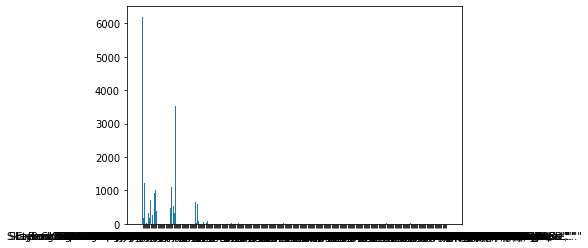

In [19]:
category_counts= Counter(category)
print(f"Total No. of Categories :",len(category_counts.keys()))
plt.bar(category_counts.keys(),category_counts.values())
plt.show() 

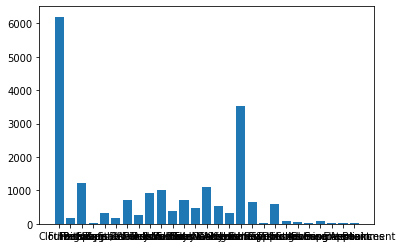

In [20]:
#only keeping the categories with more than 10 samples
new_dict={}
for key, value in category_counts.items():
  if value>10:
    new_dict[key]=value
plt.bar(new_dict.keys(),new_dict.values())
plt.show() 

In [21]:
print("total categories:", len(new_dict))
new_dict

total categories: 27


{'Automotive': 1012,
 'Baby Care': 483,
 'Bags, Wallets & Belts': 265,
 'Beauty and Personal Care': 710,
 'Cameras & Accessories': 82,
 'Clothing': 6197,
 'Computers': 578,
 'Footwear': 1227,
 'Furniture': 180,
 'Gaming': 35,
 'Health & Personal Care Appliances': 43,
 'Home & Kitchen': 24,
 'Home Decor & Festive Needs': 929,
 'Home Entertainment': 19,
 'Home Furnishing': 699,
 'Home Improvement': 81,
 'Jewellery': 3531,
 'Kitchen & Dining': 647,
 'Mobiles & Accessories': 1099,
 'Pens & Stationery': 313,
 'Pet Supplies': 30,
 'Sports & Fitness': 166,
 'Sunglasses': 35,
 'Tools & Hardware': 391,
 'Toys & School Supplies': 330,
 'Watches': 530,
 'eBooks': 15}

In [22]:
new_description=[]
new_category=[]
for i in range(len(description)):
  if category[i] in new_dict.keys():
    new_description.append(description[i])
    new_category.append(category[i])
    
new_df=pd.DataFrame()
new_df["description"]=new_description
new_df["category"]=new_category
new_df.head()

,description,category
0,key features of alisha solid women s cycling s...,Clothing
1,fabhomedecor fabric double sofa bed finish co...,Furniture
2,key features of aw bellies sandals wedges heel...,Footwear
3,key features of alisha solid women s cycling s...,Clothing
4,specifications of sicons all purpose arnica do...,Pet Supplies


In [23]:
lab_enc = preprocessing.LabelEncoder()
lab_enc.fit(new_df.category)
new_df['categorical_label'] = lab_enc.transform(new_df.category)
new_df.head()

,description,category,categorical_label
0,key features of alisha solid women s cycling s...,Clothing,5
1,fabhomedecor fabric double sofa bed finish co...,Furniture,8
2,key features of aw bellies sandals wedges heel...,Footwear,7
3,key features of alisha solid women s cycling s...,Clothing,5
4,specifications of sicons all purpose arnica do...,Pet Supplies,20


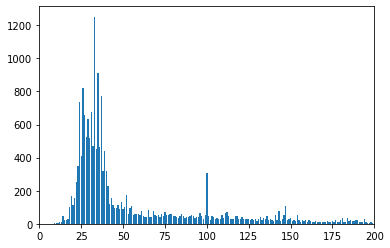

In [24]:
df=new_df["description"]
length=[]
for i in range(len(df)) :
  if type(df[i])==str:
    length.append(len(nltk.word_tokenize(df[i])))
c= Counter(length)
plt.bar(c.keys(),c.values())
plt.xlim(0,200)
plt.show() 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(new_df["description"], new_df["categorical_label"], test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [26]:
sent_length=128
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
word_index = tokenizer.word_index
voc_size = len(tokenizer.word_index) + 1
print("Vocabulary Size:", voc_size)
embedded_docs=pad_sequences(sequences,padding='post',maxlen=sent_length)
X_train=np.array(embedded_docs)

Vocabulary Size: 16950


In [27]:
sequences = tokenizer.texts_to_sequences(X_test)
embedded_docs=pad_sequences(sequences,padding='post',maxlen=sent_length)
X_test=np.array(embedded_docs)    

In [28]:
sequences = tokenizer.texts_to_sequences(X_val)
embedded_docs=pad_sequences(sequences,padding='post',maxlen=sent_length)
X_val=np.array(embedded_docs)  

In [30]:
embedding_vector_features=100
input=Input(shape=(sent_length,), name='inputs')
x=Embedding(voc_size,embedding_vector_features,input_length=sent_length)(input)
x=Bidirectional(LSTM(64))(x)
x=BatchNormalization()(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.4)(x)
truth=Dense(64,activation='relu')(x)
truth=Dense(27,activation='softmax',name='truth_')(truth)
model1=Model(inputs=input, outputs=truth)
model1.compile(loss= 'sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model1.summary()
#plot_model(model1,show_layer_names=True,show_shapes=True)

LSTM_save = ModelCheckpoint('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'LSTM_27.hdf5', save_best_only=True, monitor='val_loss', mode='min')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 128)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 128, 100)          1695000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               84480     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                1644

In [31]:
model1.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), callbacks=LSTM_save, batch_size=64, epochs=10)

Epoch 1/10
215/215 [==============================] - 41s 36ms/step - loss: 1.5156 - accuracy: 0.6217 - val_loss: 1.2788 - val_accuracy: 0.8755
Epoch 2/10
215/215 [==============================] - 7s 31ms/step - loss: 0.1920 - accuracy: 0.9482 - val_loss: 0.2994 - val_accuracy: 0.9464
Epoch 3/10
215/215 [==============================] - 7s 30ms/step - loss: 0.0722 - accuracy: 0.9814 - val_loss: 0.1835 - val_accuracy: 0.9528
Epoch 4/10
215/215 [==============================] - 7s 31ms/step - loss: 0.0491 - accuracy: 0.9847 - val_loss: 0.2126 - val_accuracy: 0.9525
Epoch 5/10
215/215 [==============================] - 7s 31ms/step - loss: 0.0269 - accuracy: 0.9920 - val_loss: 0.2474 - val_accuracy: 0.9532
Epoch 6/10
215/215 [==============================] - 6s 30ms/step - loss: 0.0288 - accuracy: 0.9906 - val_loss: 0.2545 - val_accuracy: 0.9528
Epoch 7/10
215/215 [==============================] - 6s 30ms/step - loss: 0.0263 - accuracy: 0.9930 - val_loss: 0.2493 - val_accuracy: 0.956

In [32]:
print("FOR LSTM MODEL")
saved_model=load_model('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'LSTM_27.hdf5')
y_prob = saved_model.predict(X_test)
y_pred = np.argmax(y_prob,axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %f' % precision)
recall = recall_score(y_test, y_pred,average='macro')
print('Recall: %f' % recall)
f1 = f1_score(y_test, y_pred,average='macro')
print('F1 score: %f' % f1)

FOR LSTM MODEL
Accuracy: 0.945387
Precision: 0.753877
Recall: 0.747607
F1 score: 0.746605


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'CONFUSION MATRIX - LSTM MODEL')

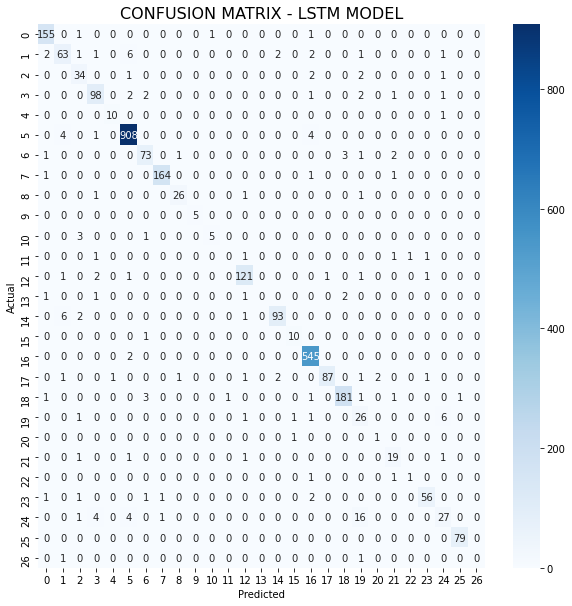

In [33]:

conf_mat = confusion_matrix(lab_enc.inverse_transform(y_test), lab_enc.inverse_transform(y_pred))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LSTM MODEL", size=16)

In [34]:
input=Input(shape=(sent_length,), name='inputs')
x=Embedding(voc_size,embedding_vector_features,input_length=sent_length)(input)
x=Conv1D(128, 5, padding='same', activation='relu' )(x)
x=MaxPooling1D(pool_size=2,strides=None)(x)
x=BatchNormalization()(x)
x=Flatten()(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.4)(x)
truth=Dense(64,activation='relu')(x)
truth=Dense(27,activation='softmax',name='truth_')(truth)
model2=Model(inputs=input, outputs=truth)
model2.compile(loss= 'sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model2.summary()
#plot_model(model3,show_layer_names=True,show_shapes=True)

CNN_save = ModelCheckpoint('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'CNN_27.hdf5', save_best_only=True, monitor='val_loss', mode='min')


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 128)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 128, 100)          1695000   
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 128)           0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 128)           512       
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097

In [35]:
model2.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), callbacks=CNN_save, batch_size=64, epochs =10)

Epoch 1/10
215/215 [==============================] - 6s 22ms/step - loss: 1.3665 - accuracy: 0.6477 - val_loss: 1.7332 - val_accuracy: 0.8820
Epoch 2/10
215/215 [==============================] - 5s 21ms/step - loss: 0.1421 - accuracy: 0.9587 - val_loss: 0.4064 - val_accuracy: 0.9454
Epoch 3/10
215/215 [==============================] - 4s 21ms/step - loss: 0.0428 - accuracy: 0.9886 - val_loss: 0.1772 - val_accuracy: 0.9556
Epoch 4/10
215/215 [==============================] - 5s 21ms/step - loss: 0.0197 - accuracy: 0.9946 - val_loss: 0.2299 - val_accuracy: 0.9556
Epoch 5/10
215/215 [==============================] - 5s 22ms/step - loss: 0.0132 - accuracy: 0.9960 - val_loss: 0.2038 - val_accuracy: 0.9556
Epoch 6/10
215/215 [==============================] - 4s 20ms/step - loss: 0.0130 - accuracy: 0.9969 - val_loss: 0.2057 - val_accuracy: 0.9579
Epoch 7/10
215/215 [==============================] - 4s 21ms/step - loss: 0.0092 - accuracy: 0.9968 - val_loss: 0.2050 - val_accuracy: 0.9610

In [40]:
print("FOR CNN MODEL")
saved_model=load_model('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'CNN_27.hdf5')
y_prob = saved_model.predict(X_test)
y_pred = np.argmax(y_prob,axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %f' % precision)
recall = recall_score(y_test, y_pred,average='macro')
print('Recall: %f' % recall)
f1 = f1_score(y_test, y_pred,average='macro')
print('F1 score: %f' % f1)

FOR CNN MODEL
Accuracy: 0.952849
Precision: 0.778632
Recall: 0.767037
F1 score: 0.765889


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'CONFUSION MATRIX - CNN MODEL')

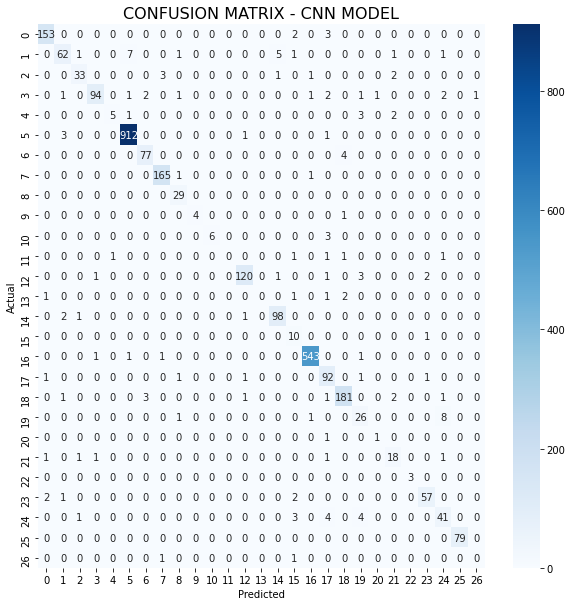

In [41]:
conf_mat = confusion_matrix(lab_enc.inverse_transform(y_test), lab_enc.inverse_transform(y_pred))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - CNN MODEL", size=16)

In [38]:
input=Input(shape=(sent_length,), name='inputs')
x=Embedding(voc_size,embedding_vector_features,input_length=sent_length)(input)
x=Conv1D(128, 5, padding='same', activation='relu' )(x)
x=MaxPooling1D(pool_size=2,strides=None)(x)
x=Bidirectional(LSTM(64))(x)
x=BatchNormalization()(x)
x=Flatten()(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.4)(x)
truth=Dense(64,activation='relu')(x)
truth=Dense(27,activation='softmax',name='truth_')(truth)
model3=Model(inputs=input, outputs=truth)
model3.compile(loss= 'sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model3.summary()
#plot_model(model5,show_layer_names=True,show_shapes=True)

CNN_LSTM_save = ModelCheckpoint('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'CNN_LSTM_27.hdf5', save_best_only=True, monitor='val_loss', mode='min')


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 128)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 128, 100)          1695000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 128)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0   

In [39]:
model3.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), callbacks=CNN_LSTM_save, batch_size=64, epochs =10)

Epoch 1/10
215/215 [==============================] - 10s 33ms/step - loss: 1.4130 - accuracy: 0.6307 - val_loss: 1.1150 - val_accuracy: 0.8898
Epoch 2/10
215/215 [==============================] - 6s 29ms/step - loss: 0.1885 - accuracy: 0.9478 - val_loss: 0.1950 - val_accuracy: 0.9525
Epoch 3/10
215/215 [==============================] - 6s 29ms/step - loss: 0.0671 - accuracy: 0.9814 - val_loss: 0.1862 - val_accuracy: 0.9535
Epoch 4/10
215/215 [==============================] - 6s 28ms/step - loss: 0.0350 - accuracy: 0.9897 - val_loss: 0.1837 - val_accuracy: 0.9590
Epoch 5/10
215/215 [==============================] - 6s 30ms/step - loss: 0.0271 - accuracy: 0.9922 - val_loss: 0.2034 - val_accuracy: 0.9559
Epoch 6/10
215/215 [==============================] - 6s 29ms/step - loss: 0.0276 - accuracy: 0.9923 - val_loss: 0.3098 - val_accuracy: 0.9501
Epoch 7/10
215/215 [==============================] - 6s 29ms/step - loss: 0.0252 - accuracy: 0.9925 - val_loss: 0.2178 - val_accuracy: 0.961

In [42]:
print("FOR C-LSTMMODEL")
saved_model=load_model('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'CNN_LSTM_27.hdf5')
y_prob = saved_model.predict(X_test)
y_pred = np.argmax(y_prob,axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %f' % precision)
recall = recall_score(y_test, y_pred,average='macro')
print('Recall: %f' % recall)
f1 = f1_score(y_test, y_pred,average='macro')
print('F1 score: %f' % f1)

FOR C-LSTMMODEL
Accuracy: 0.953189
Precision: 0.864591
Recall: 0.774949
F1 score: 0.801812


Text(0.5, 1.0, 'CONFUSION MATRIX - LSTM MODEL')

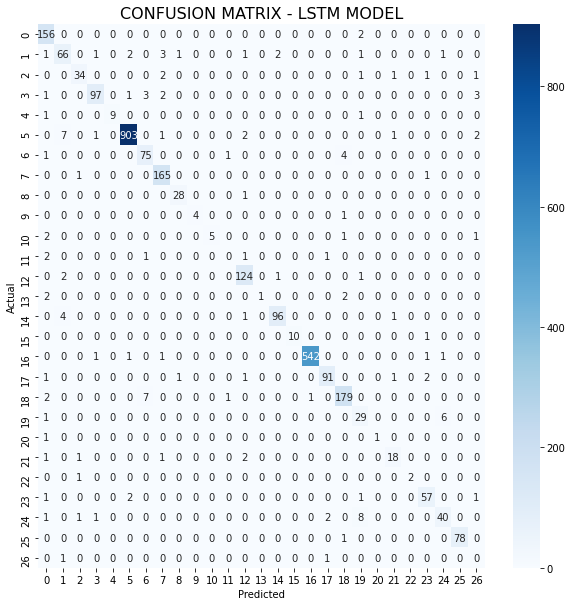

In [44]:
conf_mat = confusion_matrix(lab_enc.inverse_transform(y_test), lab_enc.inverse_transform(y_pred))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LSTM MODEL", size=16)